In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
def generate_data(samples_per_class=180):
    np.random.seed(56)
    class1 = np.random.randn(samples_per_class, 2) + np.array([2, 2])
    class2 = np.random.randn(samples_per_class, 2) + np.array([6, 6])
    class3 = np.random.randn(samples_per_class, 2) + np.array([10, 2])
    class4 = np.random.randn(samples_per_class, 2) + np.array([2, 8])
    class5 = np.random.randn(samples_per_class, 2) + np.array([10, 8])

    X = np.vstack([class1, class2, class3, class4, class5])
    y = np.array([0]*samples_per_class + [1]*samples_per_class + [2]*samples_per_class +
                 [3]*samples_per_class + [4]*samples_per_class)
    return X, y

X, y = generate_data()

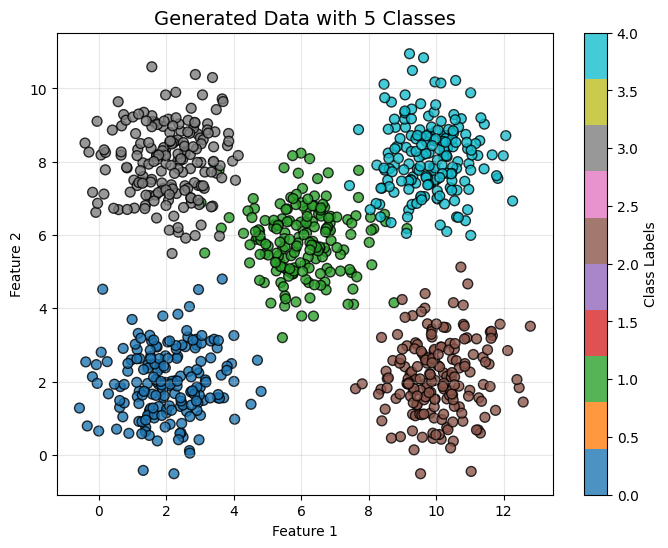

In [3]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10", s=50, edgecolor="k", alpha=0.8)

plt.title("Generated Data with 5 Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(alpha=0.3)
plt.colorbar(scatter, label="Class Labels")
plt.show()

In [4]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=56)

In [6]:
import numpy as np

class NeuralNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, lr):
        # Initialize weights
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2.0 / input_size)
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2.0 / hidden_size1)
        self.W3 = np.random.randn(hidden_size2, hidden_size3) * np.sqrt(2.0 / hidden_size2)
        self.W4 = np.random.randn(hidden_size3, output_size) * np.sqrt(2.0 / hidden_size3)
        # Initialize biases
        self.b1 = np.zeros((1, hidden_size1))
        self.b2 = np.zeros((1, hidden_size2))
        self.b3 = np.zeros((1, hidden_size3))
        self.b4 = np.zeros((1, output_size))
        self.lr = lr

    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feed_forward(self, x):
        self.hidden_input1 = np.dot(x, self.W1) + self.b1
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.hidden_input2 = np.dot(self.hidden_output1, self.W2) + self.b2
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        self.hidden_input3 = np.dot(self.hidden_output2, self.W3) + self.b3
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        self.output_input = np.dot(self.hidden_output3, self.W4) + self.b4
        self.output = self.softmax(self.output_input)
        return self.output

    def backprop(self, x, y, output):
        output_delta = output - y

        hidden_error3 = np.dot(output_delta, self.W4.T)
        hidden_delta3 = hidden_error3 * self.sigmoid(self.hidden_output3, derivative=True)

        hidden_error2 = np.dot(hidden_delta3, self.W3.T)
        hidden_delta2 = hidden_error2 * self.sigmoid(self.hidden_output2, derivative=True)

        hidden_error1 = np.dot(hidden_delta2, self.W2.T)
        hidden_delta1 = hidden_error1 * self.sigmoid(self.hidden_output1, derivative=True)

        # Update weights and biases
        self.W4 -= np.dot(self.hidden_output3.T, output_delta) * self.lr
        self.b4 -= np.sum(output_delta, axis=0, keepdims=True) * self.lr
        self.W3 -= np.dot(self.hidden_output2.T, hidden_delta3) * self.lr
        self.b3 -= np.sum(hidden_delta3, axis=0, keepdims=True) * self.lr
        self.W2 -= np.dot(self.hidden_output1.T, hidden_delta2) * self.lr
        self.b2 -= np.sum(hidden_delta2, axis=0, keepdims=True) * self.lr
        self.W1 -= np.dot(x.T, hidden_delta1) * self.lr
        self.b1 -= np.sum(hidden_delta1, axis=0, keepdims=True) * self.lr

    def train(self, x, y):
        output = self.feed_forward(x)
        self.backprop(x, y, output)

In [7]:
input_size = X_train.shape[1]
hidden_size = 22
output_size = y_train.shape[1] # Corrected to take the second element of y_train.shape

lr, epochs = 0.0015, 1500
nn = NeuralNet(input_size, hidden_size, hidden_size, hidden_size, output_size, lr)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # Training step
    nn.train(X_train, y_train)

    # Forward pass
    train_pred = nn.feed_forward(X_train)
    val_pred = nn.feed_forward(X_val)

    # Loss computation (cross-entropy)
    train_loss = -np.mean(np.sum(y_train * np.log(train_pred + 1e-9), axis=1))
    val_loss   = -np.mean(np.sum(y_val * np.log(val_pred + 1e-9), axis=1))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Accuracy computation
    train_acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    val_acc   = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc*100:.2f}%, Val Acc: {val_acc*100:.2f}%")

Epoch    0 | Train Loss: 1.6258, Val Loss: 1.6158 | Train Acc: 22.78%, Val Acc: 23.89%
Epoch  100 | Train Loss: 0.6069, Val Loss: 0.5972 | Train Acc: 79.81%, Val Acc: 73.33%
Epoch  200 | Train Loss: 0.3951, Val Loss: 0.4000 | Train Acc: 85.93%, Val Acc: 85.56%
Epoch  300 | Train Loss: 0.2676, Val Loss: 0.2683 | Train Acc: 84.63%, Val Acc: 85.00%
Epoch  400 | Train Loss: 0.2340, Val Loss: 0.2334 | Train Acc: 89.63%, Val Acc: 88.33%
Epoch  500 | Train Loss: 0.2136, Val Loss: 0.2153 | Train Acc: 91.67%, Val Acc: 91.11%
Epoch  600 | Train Loss: 0.1947, Val Loss: 0.2005 | Train Acc: 92.96%, Val Acc: 93.89%
Epoch  700 | Train Loss: 0.1755, Val Loss: 0.1861 | Train Acc: 94.07%, Val Acc: 93.89%
Epoch  800 | Train Loss: 0.2002, Val Loss: 0.2140 | Train Acc: 92.41%, Val Acc: 91.67%
Epoch  900 | Train Loss: 0.1370, Val Loss: 0.1577 | Train Acc: 95.00%, Val Acc: 93.33%
Epoch 1000 | Train Loss: 0.1825, Val Loss: 0.1986 | Train Acc: 92.04%, Val Acc: 92.22%
Epoch 1100 | Train Loss: 0.0618, Val Loss: 

In [8]:
test_pred = nn.feed_forward(X_test)
test_pred_classes = np.argmax(test_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_test_classes, test_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.96      0.71      0.82        35
           2       1.00      0.97      0.99        34
           3       0.98      1.00      0.99        46
           4       0.77      1.00      0.87        34

    accuracy                           0.93       180
   macro avg       0.94      0.93      0.93       180
weighted avg       0.94      0.93      0.93       180



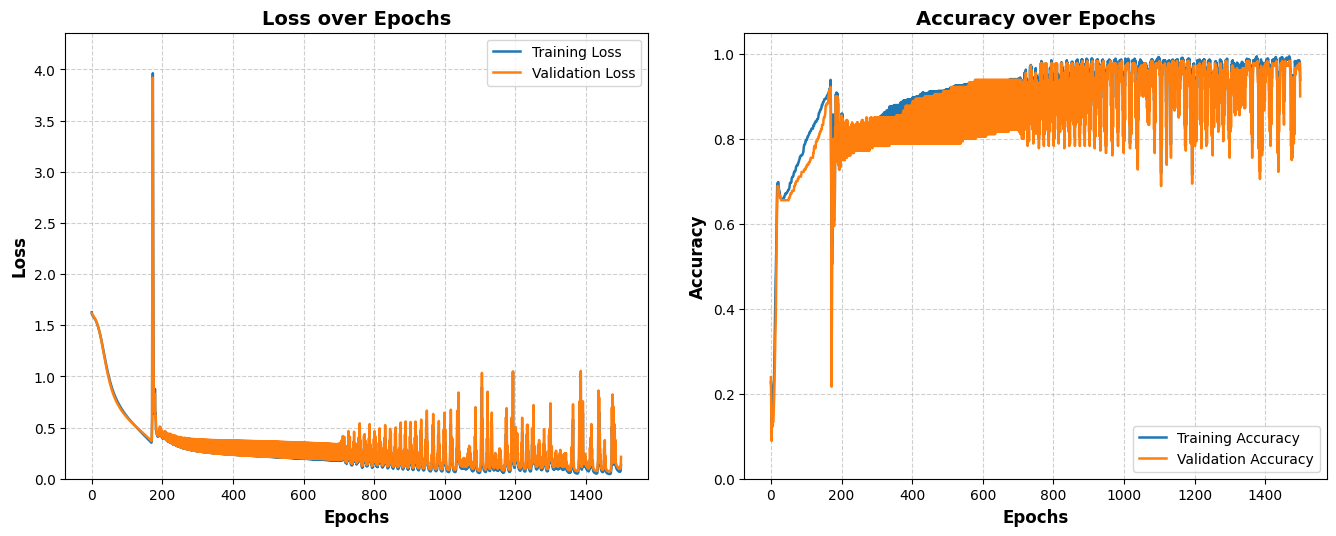

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linestyle='-', color='#1f77b4', linewidth=1.8)  # Muted blue
plt.plot(val_losses, label="Validation Loss", color='#ff7f0e', linewidth=1.8)  # Muted orange
plt.xlabel("Epochs", fontsize=12, fontweight='bold')
plt.ylabel("Loss", fontsize=12, fontweight='bold')
plt.title("Loss over Epochs", fontsize=14, fontweight='bold')
plt.legend(frameon=True, fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, max(max(train_losses), max(val_losses)) * 1.1)
plt.tick_params(axis='both', which='major', labelsize=10)


# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy", linestyle='-', color='#1f77b4', linewidth=1.8)  # Muted blue
plt.plot(val_accuracies, label="Validation Accuracy", color='#ff7f0e', linewidth=1.8)  # Muted orange
plt.xlabel("Epochs", fontsize=12, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold')
plt.title("Accuracy over Epochs", fontsize=14, fontweight='bold')
plt.legend(frameon=True, fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05)
plt.tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout(pad=3.0)
plt.show()

Test Accuracy: 93.33%


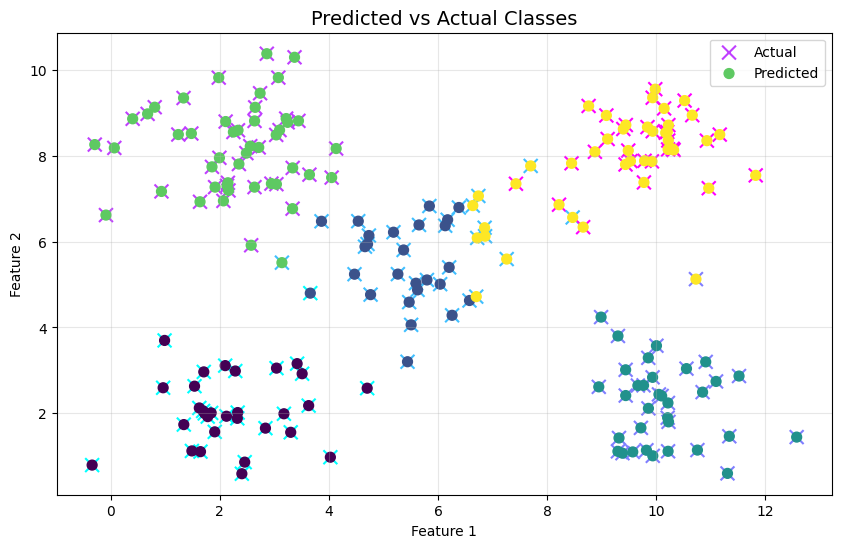

In [10]:
test_output = nn.feed_forward(X_test)
predicted_classes = np.argmax(test_output, axis=1)
actual_classes = np.argmax(y_test, axis=1)
test_accuracy = accuracy_score(actual_classes, predicted_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='cool', s=100, marker='x', label='Actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='viridis', s=50, marker='o', label='Predicted')
plt.title("Predicted vs Actual Classes", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

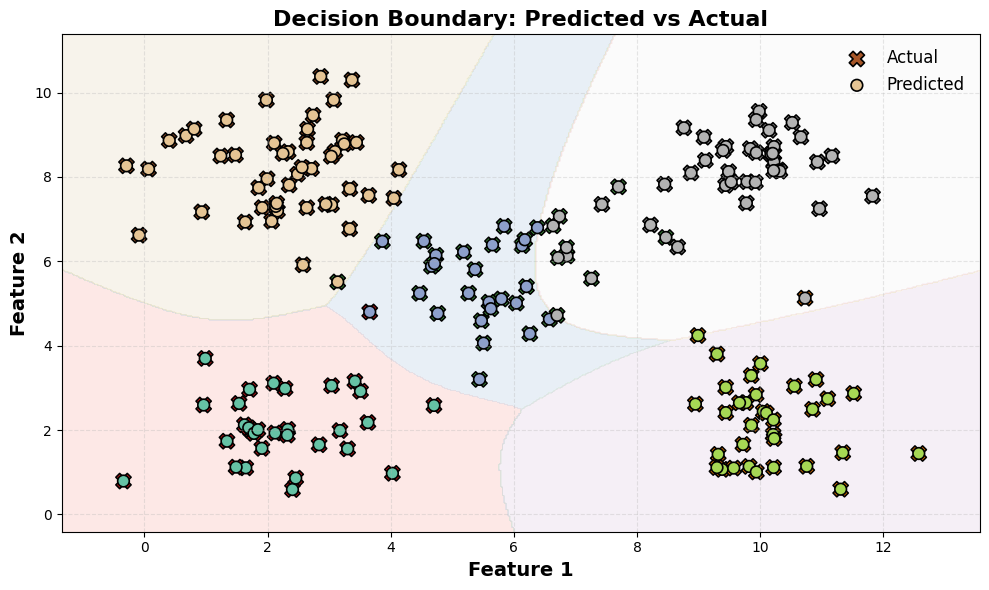

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.03),
                     np.arange(y_min, y_max, 0.03))

Z = np.argmax(nn.feed_forward(np.c_[xx.ravel(), yy.ravel()]), axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))

plt.contourf(xx, yy, Z, alpha=0.3, cmap='Pastel1')

scatter_actual = plt.scatter(
    X_test[:, 0], X_test[:, 1], c=actual_classes, cmap='Set1', s=120, marker='X',
    edgecolor='black', linewidth=1.2, label='Actual')

scatter_pred = plt.scatter(
    X_test[:, 0], X_test[:, 1], c=predicted_classes, cmap='Set2', s=70, marker='o',
    edgecolor='black', linewidth=1.2, label='Predicted')

plt.title("Decision Boundary: Predicted vs Actual", fontsize=16, fontweight='bold')
plt.xlabel("Feature 1", fontsize=14, fontweight='bold')
plt.ylabel("Feature 2", fontsize=14, fontweight='bold')

plt.legend(loc='upper right', fontsize=12, frameon=False)

plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()

Confusion Matrix:
[[30  1  0  0  0]
 [ 0 25  0  1  9]
 [ 0  0 33  0  1]
 [ 0  0  0 46  0]
 [ 0  0  0  0 34]]


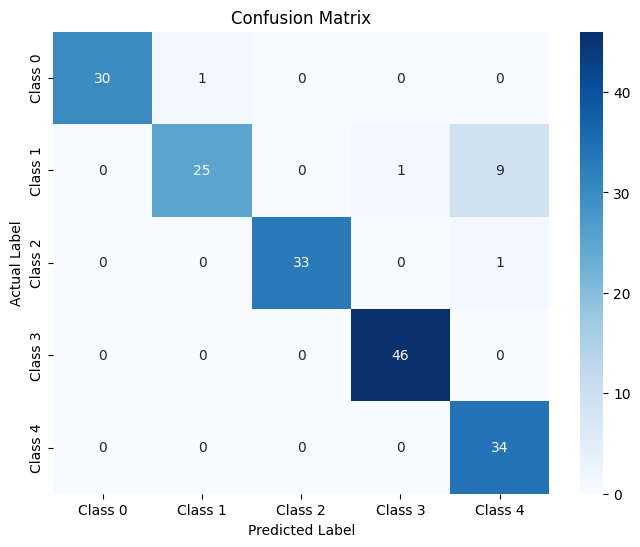

In [17]:
cm = confusion_matrix(actual_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix
plt.figure(figsize=(8, 6))
class_labels = [f'Class {i}' for i in np.unique(actual_classes)]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

/tmp/ipython-input-341603191.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', output_size)


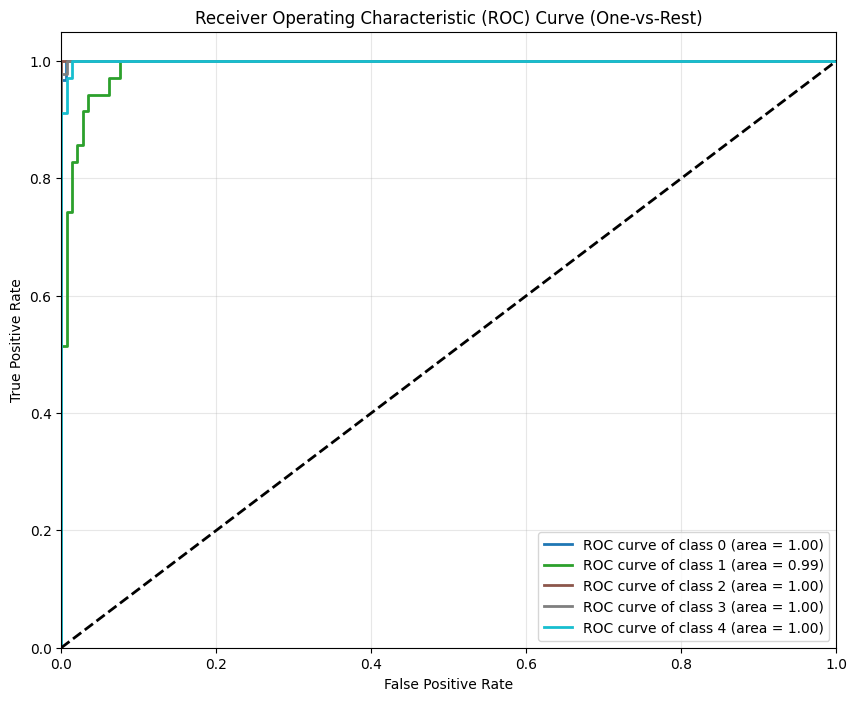

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=np.arange(output_size))

test_pred_proba = nn.feed_forward(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_size):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', output_size)
for i in range(output_size):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label='ROC curve of class {0} (area = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-2267278087.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', output_size)


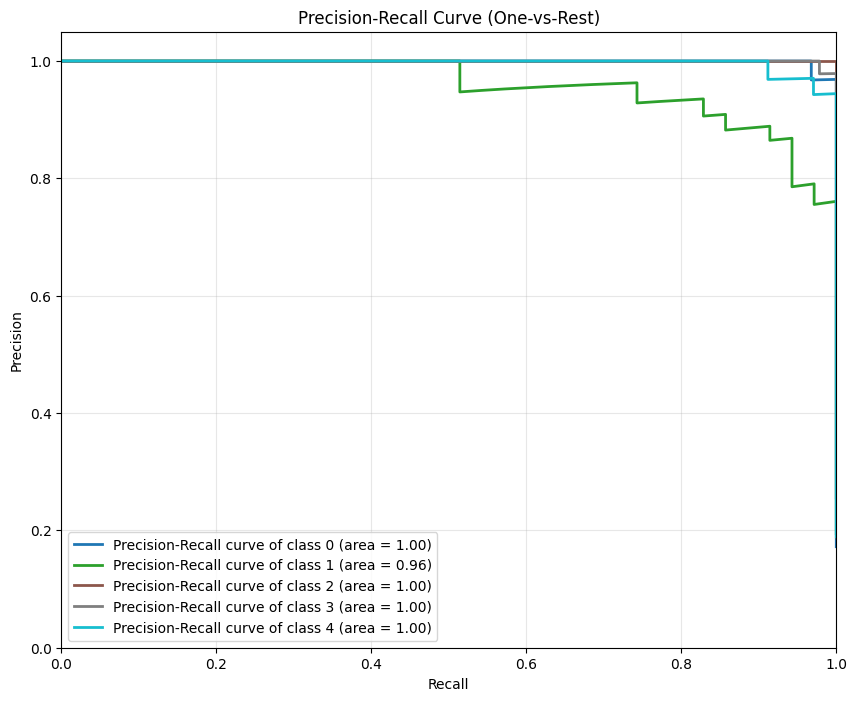

In [19]:

from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and area for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(output_size):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], test_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], test_pred_proba[:, i])

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', output_size)
for i in range(output_size):
    plt.plot(recall[i], precision[i], color=colors(i), lw=2,
             label='Precision-Recall curve of class {0} (area = {1:.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()